In [1]:
import sys

sys.path.append("..")

In [2]:
import os
from dataclasses import dataclass
from typing import *

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import torch
from sklearn.model_selection import StratifiedKFold
from tqdm import tqdm

from src.utils import Jbl, check_exist, mkdir, rmdir

%matplotlib inline

In [3]:
run_name = "exp015"

@dataclass
class InputPath:
    _prefix: str = "../input"
    train_images: str = f"{_prefix}/christ-train-imgs.npz"
    train_labels: str = f"{_prefix}/christ-train-labels.npz"
    test_images: str = f"{_prefix}/christ-test-imgs.npz"
        
        
@dataclass
class OutputPath:
    _prefix: str = "../output"
    logs: str = f"{_prefix}/logs"
    model: str = f"{_prefix}/model"
    submission: str = f"{_prefix}/submission"
     
        
def load_npz(path: str) -> np.array:
    return np.load(path)["arr_0"]


def generate_kf() -> Generator:
    kf = StratifiedKFold(
        n_splits=5,
        shuffle=True,
        random_state=42,
    )
    return kf

In [4]:
train_labels = load_npz(InputPath.train_labels)
train = pd.DataFrame({"target": train_labels})
kf = generate_kf()
kf_generator = kf.split(train, train["target"])
for fold_i, (tr_idx, val_idx) in enumerate(kf_generator):
    train.loc[val_idx, "fold"] = fold_i
train = train.assign(fold=train["fold"].astype(int))
train.head()

,target,fold
0,5,0
1,11,3
2,8,2
3,2,1
4,6,0


In [5]:
preds_train = np.zeros((len(train), 13))
for i in tqdm(range(5)):
    train_fold = train.loc[train["fold"]==i, :]
    preds = torch.load(f"{OutputPath.model}/{run_name}_{i}.pth")["preds"]
    preds_train[train_fold.index] = preds
    
preds_test = Jbl.load(f"{OutputPath.model}/preds_test_{run_name}.jbl")

100%|██████████| 5/5 [00:03<00:00,  1.58it/s]


In [6]:
train_concat = pd.concat(
    (train, 
     pd.DataFrame(preds_train, columns=[f"pred_{i}" for i in range(13)]),
     pd.DataFrame(np.max(preds_train, axis=1), columns=["pred_max"]),
     pd.DataFrame(np.argmax(preds_train, axis=1), columns=["pred"]),
    ), axis=1
)
train_concat = train_concat.assign(is_correct=train_concat["target"]==train_concat["pred"])
train_concat

,target,fold,pred_0,pred_1,pred_2,pred_3,pred_4,pred_5,pred_6,pred_7,pred_8,pred_9,pred_10,pred_11,pred_12,pred_max,pred,is_correct
0,5,0,0.019089,0.052594,0.052257,0.192222,0.018309,0.465496,0.009904,0.015717,0.113033,0.007952,0.006368,0.043748,0.003310,0.465496,5,True
1,11,3,0.020603,0.009778,0.006987,0.027276,0.014714,0.063567,0.175726,0.003042,0.004323,0.026713,0.067917,0.108210,0.471144,0.471144,12,False
2,8,2,0.000160,0.000103,0.000232,0.000161,0.000050,0.000059,0.004807,0.000227,0.992865,0.000110,0.000778,0.000366,0.000082,0.992865,8,True
3,2,1,0.003252,0.017561,0.003059,0.000744,0.003806,0.888198,0.005020,0.002414,0.000498,0.074144,0.000213,0.000346,0.000745,0.888198,5,False
4,6,0,0.355985,0.002656,0.285683,0.007621,0.050021,0.066594,0.115026,0.004091,0.002225,0.053047,0.037239,0.018104,0.001707,0.355985,0,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
649,2,0,0.016630,0.134260,0.567459,0.010146,0.032900,0.003924,0.001899,0.021623,0.012582,0.001458,0.083350,0.024371,0.089397,0.567459,2,True
650,3,0,0.032097,0.112309,0.025308,0.530834,0.060470,0.149396,0.004440,0.008043,0.001866,0.005822,0.004007,0.008497,0.056911,0.530834,3,True
651,2,4,0.004765,0.001187,0.874415,0.003769,0.002136,0.096464,0.006299,0.004957,0.000543,0.001735,0.001469,0.001620,0.000640,0.874415,2,True
652,0,0,0.302747,0.145269,0.085976,0.030211,0.020270,0.178574,0.020102,0.008980,0.075229,0.004121,0.024579,0.082157,0.021783,0.302747,0,True


In [7]:
print(
    train_concat.loc[train_concat["target"]==train_concat["pred"], :].pred_max.mean(),
    train_concat.loc[train_concat["target"]==train_concat["pred"], :].pred_max.median(),
)

0.6822068846615861 0.7078755863010884


In [8]:
print(
    train_concat.loc[train_concat["target"]!=train_concat["pred"], :].pred_max.mean(),
    train_concat.loc[train_concat["target"]!=train_concat["pred"], :].pred_max.median(),
)

0.484116878307808 0.44277042895555496


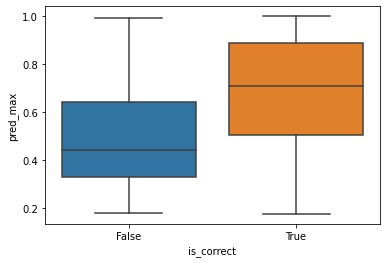

In [9]:
sns.boxplot(data=train_concat, x="is_correct", y="pred_max")
plt.show()

In [10]:
test = pd.DataFrame(np.array(preds_test).mean(axis=0), columns=[f"pred_{i}" for i in range(13)])
test = test.assign(
    pred_max = np.max(np.array(preds_test).mean(axis=0), axis=1),
    pred=np.argmax(np.array(preds_test).mean(axis=0), axis=1),
)
test

,pred_0,pred_1,pred_2,pred_3,pred_4,pred_5,pred_6,pred_7,pred_8,pred_9,pred_10,pred_11,pred_12,pred_max,pred
0,0.011398,0.007686,0.709521,0.006769,0.005170,0.230114,0.010010,0.001778,0.001665,0.002288,0.003380,0.005992,0.004229,0.709521,2
1,0.017877,0.035713,0.137203,0.369732,0.091073,0.020927,0.012650,0.058984,0.011033,0.019647,0.087361,0.115131,0.022670,0.369732,3
2,0.002971,0.006194,0.240478,0.024771,0.028008,0.019247,0.001227,0.003141,0.006750,0.009011,0.632952,0.017120,0.008129,0.632952,10
3,0.042474,0.028104,0.292420,0.301755,0.084438,0.056771,0.010028,0.016931,0.031895,0.023092,0.035679,0.059223,0.017190,0.301755,3
4,0.123305,0.171715,0.060405,0.202644,0.150753,0.042392,0.015479,0.024460,0.018867,0.030009,0.018034,0.122203,0.019734,0.202644,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
492,0.012895,0.027526,0.416613,0.062340,0.156871,0.179323,0.004932,0.019110,0.010343,0.033725,0.023352,0.013282,0.039689,0.416613,2
493,0.077964,0.014371,0.347936,0.008272,0.031662,0.163858,0.010672,0.012884,0.015640,0.196487,0.005569,0.067831,0.046855,0.347936,2
494,0.001106,0.002457,0.020293,0.002862,0.003713,0.001828,0.524223,0.003378,0.357076,0.001322,0.006466,0.069481,0.005797,0.524223,6
495,0.075671,0.029470,0.039095,0.018279,0.023381,0.029643,0.508566,0.017803,0.021015,0.103610,0.037049,0.078822,0.017596,0.508566,6


In [14]:
threshold = train_concat.loc[train_concat["target"]==train_concat["pred"], :].pred_max.mean()
print(threshold)

test_pseudo = test[test["pred_max"]>=threshold]
test_pseudo

0.6822068846615861


,pred_0,pred_1,pred_2,pred_3,pred_4,pred_5,pred_6,pred_7,pred_8,pred_9,pred_10,pred_11,pred_12,pred_max,pred
0,0.011398,0.007686,0.709521,0.006769,0.005170,0.230114,0.010010,0.001778,0.001665,0.002288,0.003380,0.005992,0.004229,0.709521,2
7,0.002809,0.091888,0.006446,0.013722,0.022130,0.007215,0.003381,0.742875,0.034093,0.013877,0.003815,0.051147,0.006603,0.742875,7
8,0.006820,0.004019,0.011081,0.009642,0.009099,0.010049,0.000939,0.940955,0.001855,0.001395,0.001737,0.001434,0.000976,0.940955,7
10,0.004820,0.012069,0.012960,0.062545,0.003898,0.042839,0.760302,0.013426,0.014961,0.028470,0.011616,0.019457,0.012637,0.760302,6
12,0.013458,0.015933,0.852707,0.026946,0.018096,0.006582,0.005735,0.003627,0.031232,0.003153,0.012716,0.004633,0.005183,0.852707,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
476,0.002000,0.001329,0.000151,0.001197,0.000255,0.001527,0.968436,0.000246,0.000627,0.000430,0.008613,0.001727,0.013461,0.968436,6
477,0.001200,0.004187,0.897584,0.005385,0.009287,0.028431,0.005256,0.018180,0.005903,0.002181,0.011676,0.003735,0.006996,0.897584,2
478,0.002305,0.005597,0.891157,0.076879,0.003396,0.008646,0.001054,0.001397,0.001779,0.001235,0.004483,0.001197,0.000876,0.891157,2
482,0.010042,0.041166,0.008350,0.002886,0.017983,0.005743,0.004837,0.006612,0.003322,0.886454,0.006691,0.004284,0.001630,0.886454,9


In [18]:
pseudo_dict: Dict[int, int] = {}
for idx, pred in zip(test_pseudo.index, test_pseudo["pred"]):
    pseudo_dict[idx] = pred

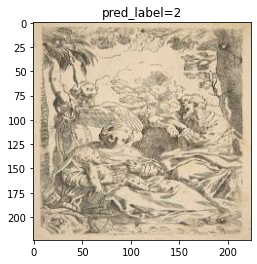

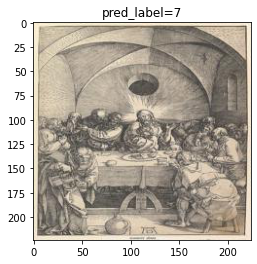

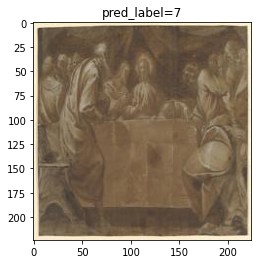

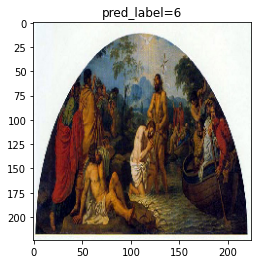

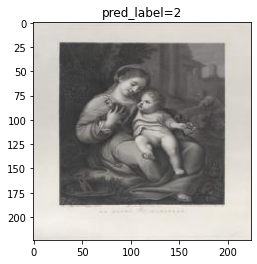

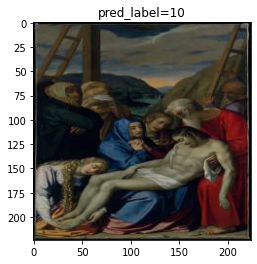

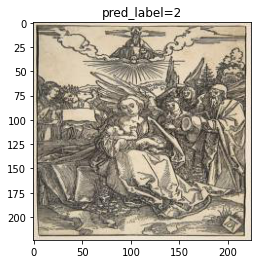

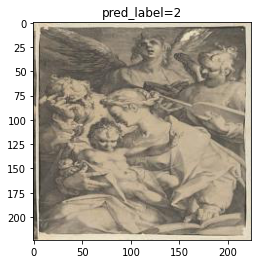

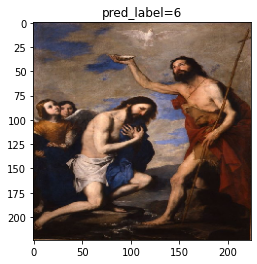

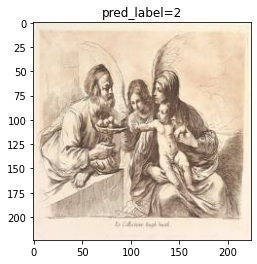

In [13]:
test_images = load_npz(InputPath.test_images)
for i, idx in enumerate(test[test["pred_max"]>=threshold].index):
    pred_label = np.argmax(np.array(preds_test).mean(axis=0)[idx, :])
    test_image = test_images[idx]
    plt.imshow(test_image)
    plt.title(f"pred_label={pred_label}")
    plt.show()
    if i == 9:
        break